<a id="top"></a>
# ULLYSES Data Walkthrough Notebook

***

## Learning Goals

By the end of this tutorial, you will:

- Know the different types of high level science products (HLSPs) offered by the ULLYSES team.
- Be able to open each file and view its contents and metadata.
- Understand how to use each type of HSLP.

## Table of Contents
**0. [Introduction](#introduction)**

**1. [HLSP Descriptions and Filename Convention](#hlspdescrip)**

**2. [HLSP File Exploration](#hlspformats)**

\- 2.1 [Single-epoch Spectra](#single)

\- 2.2 [Time-series Spectra](#tss)

\- 2.3 [WFC3 Drizzled Images](#drizzle)

<a id="introduction"></a>
## Introduction

The Hubble Space Telescope’s (HST) Ultraviolet Legacy Library of Young Stars as Essential Standards ([ULLYSES](https://ullyses.stsci.edu/index.html) program has devoted approximately 1,000 HST orbits to the production of an ultraviolet spectroscopic library of young high- and low-mass stars in the local universe. This Director’s Discretionary program was designed to take advantage of HST’s unique UV capabilities, as both high- and low-mass stars feature different complex UV emission processes that strongly impact their surroundings, but are difficult to model. The UV emission from star formation is central to a wide range of vital astrophysical issues, ranging from cosmic reionization to the formation of planets.

The ULLYSES program uniformly sampled the fundamental astrophysical parameter space for each mass regime — including spectral type, luminosity class, and metallicity for massive OB stars (in the Magellanic Clouds and two other lower-metallicity nearby galaxies) and the mass, age, and disk accretion rate for low-mass T Tauri stars (in eight young Galactic associations). The data were gathered over a three-year period, from Cycle 27 through Cycle 29 (2020-2022). The design and targets of these observations were determined in partnership with the astronomical community, allowing researchers from around the world to help develop the final program and to plan coordinated observations with other space- and ground-based telescopes.

The ULLYSES team produces several types of High Level Science Products (HLSPs), which we will walk through in this notebook. Products are made using both archival data and new HST observations obtained through the ULLYSES program. Data products are available from the [ULLYSES website](https://ullyses.stsci.edu/ullyses-download.html) (HLSPs and contributing data), the [MAST Data Discovery Portal](https://mast.stsci.edu/) (HLSPs and contributing data), or directly as a High-Level Science Product collection using the [DOI](https://archive.stsci.edu/hlsp/ullyses) (HLSPs only).

### Imports
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astroy.wcs WCS* to create world coordinate system objects for plotting WFC3 images
- *astropy.table Table* for creating tidy tables of the data
- *astropy.time Time* to create Time objects for timeseries data
- *matplotlib.pyplot* for plotting data
- *%matplotlib widget* enables interactive plotting - install using `pip install ipympl`
- *os* to interact with the operating system
- *Path* to create product and data directories
- *shutil* to perform directory and file operations

In [36]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.time import Time
import matplotlib.pyplot as plt
%matplotlib widget
plt.rcParams['figure.figsize'] = 10, 6
plt.style.use('seaborn-v0_8-colorblind')
import os
from pathlib import Path
import shutil

***

<a id="hlspdescrip"></a>
## HLSP Descriptions and Filename Convention

The file names for ULLYSES science data products follow a naming scheme which encodes the target designation and the instruments and observing configuration(s) that contribute to the product. However, not all products will appear in the early releases. File names have the form:

`hlsp_ullyses_<telescope>_<instrument>_<target>_<opt_elem>_<version>_<product-type>`

where

`<target>` is the target name
`<version>` is the data release identifier (dr1, dr2, etc.)

The `<telescope>`, `<instrument>`, `<opt_elem>`, and `<product-type>` templates take names from the following table:

| Description                                                                                                  | Telescope | Instrument    | Opt-Elem                                        | Product-Type      | Level |
|--------------------------------------------------------------------------------------------------------------|-----------|---------------|-------------------------------------------------|-------------------|-------|
| Custom calibrated STIS 1D spectra                                                                            | hst       | stis          | g230l, g430l, or g750l                             | spec.fits         | 0     |
| STIS custom calibration parameter files                                                                      | hst       | stis          | g230l, g430l, or g750l                             | spec.yaml         | 0     |
| STIS echelle single grating, where the orders have been extracted and merged.                                | hst       | stis          | e140l, e230h, e140m, or e230m                      | mspec.fits        | 1     |
| Combined spectra, with common instrument and  grating, and in some cases with different cenwave settings.    | hst       | cos           | g130m, g160m, g185m, or g230l                      | cpsec.fits        | 2     |
|                                                                                                              |           | stis          | e140l, e230h, e140m, e230m, g230l, g430l, or g750l |                   |       |
| Combined spectra, with common instrument, different gratings and cenwave settings, and grouped by resolution | fuse      | fuv           | lwrs or mdrs                                    | cspec.fits        | 3     |
|                                                                                                              | hst       | cos           | g130m-g160m-g185m                               |                   |       |
|                                                                                                              |           | stis          | e140h-e230h, g140m-e230m or g230l-g430l-g750l |                   |       |
| All instruments and settings abutted together*                                                               | hst       | cos-stis      | uv or uv-opt                                    | preview-spec.fits | 4     |
|                                                                                                              | hst-fuse  | fuse-cos-stis | uv-opt                                          |                   |       |
| Exposure-level time-series spectra                                                                           | hst       | cos           | g130m or g160m                                    | tss.fits          | 5     |
|                                                                                                              | lcogt     | 04m           | v-ip                                            |                   |       |
| Subexposure-level time-series spectra                                                                        | hst       | cos           | g130m or g160m                                    | split-tss.fits    | 5     |
| WFC3 drizzled images                                                                                         | hst       | wfc3          | f225w, f275w, f336w, f475w or f814w               | drc.fits          | 6     |

***

<a id="hlspformats"></a>
## HLSP File Formats

Most High Level Science Products are in FITS format. The organization of each FITS file depends on the HLSP type. There are three broad categories of HLSPs: single-epoch spectra, time-series spectra, and drizzled images.

<a id="single"></a>
### Single Epoch Spectra

#### FITS File Structure

Spectral data and information is stored in two BINTABLE extensions:
- a Science extension for the combined product, and
- a matching Provenance extension to record attributes of each spectrum that contributed to the combined product

Let's start by downloading the available data products for a target taken in a single epoch and look around.

In [ ]:
# Use curl to download the files -- these are the level 2, 3, and 4 data products for the target SK-67 195
!curl -L -X GET "https://mast.stsci.edu/api/v0.1/Download/file?uri=mast%3AHLSP%2Fullyses%2Fsk-67d195%2Fdr6%2Fhlsp_ullyses_hst_cos-stis_sk-67d195_uv_dr6_preview-spec.fits" --output "hlsp_ullyses_hst_cos-stis_sk-67d195_uv_dr6_preview-spec.fits" --fail --create-dirs

!curl -L -X GET "https://mast.stsci.edu/api/v0.1/Download/file?uri=mast%3AHLSP%2Fullyses%2Fsk-67d195%2Fdr6%2Fhlsp_ullyses_hst_cos_sk-67d195_g130m-g160m-g185m_dr6_cspec.fits" --output "hlsp_ullyses_hst_cos_sk-67d195_g130m-g160m-g185m_dr6_cspec.fits" --fail --create-dirs

!curl -L -X GET "https://mast.stsci.edu/api/v0.1/Download/file?uri=mast%3AHLSP%2Fullyses%2Fsk-67d195%2Fdr6%2Fhlsp_ullyses_hst_cos_sk-67d195_g130m_dr6_cspec.fits" --output "hlsp_ullyses_hst_cos_sk-67d195_g130m_dr6_cspec.fits" --fail --create-dirs

!curl -L -X GET "https://mast.stsci.edu/api/v0.1/Download/file?uri=mast%3AHLSP%2Fullyses%2Fsk-67d195%2Fdr6%2Fhlsp_ullyses_hst_cos_sk-67d195_g160m_dr6_cspec.fits" --output "hlsp_ullyses_hst_cos_sk-67d195_g160m_dr6_cspec.fits" --fail --create-dirs

!curl -L -X GET "https://mast.stsci.edu/api/v0.1/Download/file?uri=mast%3AHLSP%2Fullyses%2Fsk-67d195%2Fdr6%2Fhlsp_ullyses_hst_cos_sk-67d195_g185m_dr6_cspec.fits" --output "hlsp_ullyses_hst_cos_sk-67d195_g185m_dr6_cspec.fits" --fail --create-dirs

!curl -L -X GET "https://mast.stsci.edu/api/v0.1/Download/file?uri=mast%3AHLSP%2Fullyses%2Fsk-67d195%2Fdr6%2Fhlsp_ullyses_hst_stis_sk-67d195_e230m_dr6_cspec.fits" --output "hlsp_ullyses_hst_stis_sk-67d195_e230m_dr6_cspec.fits" --fail --create-dirs

\
Six datasets were just downloaded. They include:

Level 2
- hlsp_ullyses_hst_cos_sk-67d195_g130m_dr6_cspec.fits
- hlsp_ullyses_hst_cos_sk-67d195_g160m_dr6_cspec.fits
- hlsp_ullyses_hst_cos_sk-67d195_g185m_dr6_cspec.fits
- hlsp_ullyses_hst_stis_sk-67d195_e230m_dr6_cspec.fits

Level 3
- hlsp_ullyses_hst_cos_sk-67d195_g130m-g160m-g185m_dr6_cspec.fits

Level 4
- hlsp_ullyses_hst_cos-stis_sk-67d195_uv_dr6_preview-spec.fits

We will first go through the level 4 file, which is the data product with all instruments and settings abutted together.

In [2]:
# Create a variable to point to the file we just downloaded
spec_file = Path('./hlsp_ullyses_hst_cos-stis_sk-67d195_uv_dr6_preview-spec.fits')

# Use Astropy.fits to open the fits file and create a header data unit (HDU)
# More info on fits files and HDUs can be found at: https://docs.astropy.org/en/stable/io/fits/
spec_hdu = fits.open(spec_file)

# Print out some information about the format and data in this HDU
print(spec_hdu.info())

Filename: hlsp_ullyses_hst_cos-stis_sk-67d195_uv_dr6_preview-spec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   ()      
  1  SCIENCE       1 BinTableHDU     33   1R x 5C   [84033E, 84033E, 84033E, 84033E, 84033E]   
  2  PROVENANCE    1 BinTableHDU     47   14R x 16C   [64A, 32A, 32A, 32A, 32A, 32A, 32A, 32A, D, 32A, D, D, D, D, D, D]   
None


\
From the filename, we can see:
- the telescope used is HST
- the instrument used are COS and STIS
- the optical element is UV (in this case, many optical elements made up this data product)
- this file was created for data release 6

Now we'll look at the science and provenance extensions.

#### Single-epoch Science Table

Various elements of a single spectrum of M wavelength bins are stored in a single table row; each element is stored in a separate field (i.e., column). The table extension headers also contain informative metadata.

In [3]:
# Print the columns in the science extension of the HDU - the science extension is index 1
print(spec_hdu[1].columns)

ColDefs(
    name = 'WAVELENGTH'; format = '84033E'; unit = 'Angstrom'
    name = 'FLUX'; format = '84033E'; unit = 'erg /s /cm**2 /Angstrom'
    name = 'ERROR'; format = '84033E'; unit = 'erg /s /cm**2 /Angstrom'
    name = 'SNR'; format = '84033E'
    name = 'EFF_EXPTIME'; format = '84033E'; unit = 's'
)


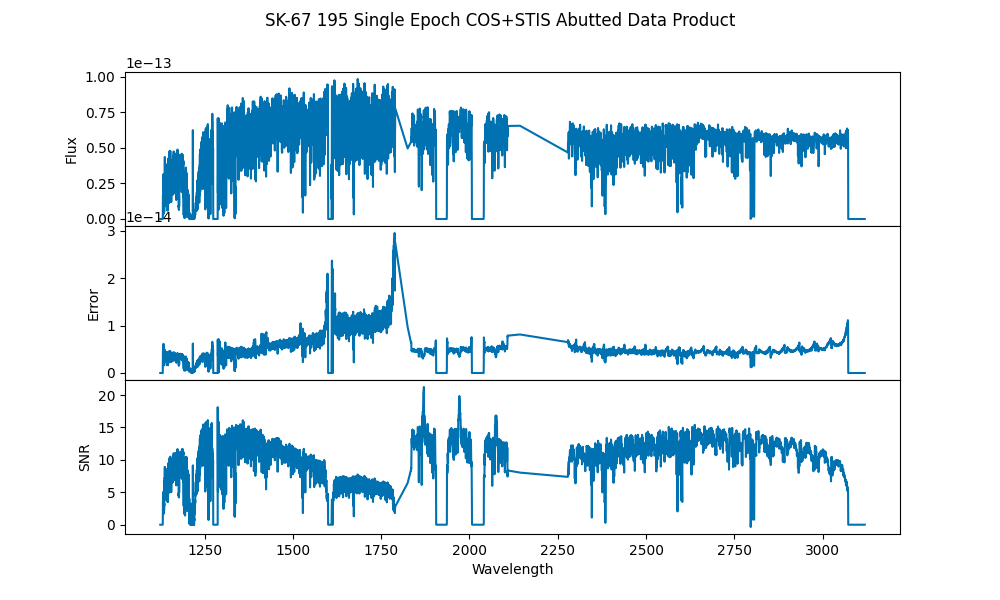

In [4]:
# Now let's plot the flux, error, wavelength, and SNR for this dataset
# To get these values we use ".data" to access the data in the science extension of the HDU
# To access the header of this extension instead, we would use ".header"

wavelength = spec_hdu[1].data['WAVELENGTH'][0]
flux = spec_hdu[1].data['FLUX'][0]
snr = spec_hdu[1].data['SNR'][0]
error = spec_hdu[1].data['ERROR'][0]

# Set up a quick function to bin the spectra
def downsample_1d(myarr,factor):
    """
    Downsample a 1D array by averaging over *factor* pixels.
    Crops right side if the shape is not a multiple of factor.
    Got this specific function from "Adam Ginsburg's python codes" on agpy

    myarr : numpy array

    factor : how much you want to rebin the array by
    """
    xs = myarr.shape[0]
    crarr = myarr[:xs-(xs % int(factor))]
    dsarr = np.mean(np.concatenate(
                     [[crarr[i::factor] for i in range(factor)]]
                     ), axis=0)

    return dsarr

# Set up the plot
fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
axs[0].plot(downsample_1d(wavelength, 10), downsample_1d(flux, 10))
axs[1].plot(downsample_1d(wavelength, 10), downsample_1d(error, 10))
axs[2].plot(downsample_1d(wavelength, 10), downsample_1d(snr, 10))

plt.suptitle('SK-67 195 Single Epoch COS+STIS Abutted Data Product')
axs[0].set_ylabel('Flux')
axs[1].set_ylabel('Error')
axs[2].set_ylabel('SNR')
plt.xlabel('Wavelength')
            
plt.show()

#### Single-epoch Provenance Table

Select metadata for each spectrum that contributes to the combined spectrum in the SCIENCE extension will populate a row in the provenance table. The fields in the table are metadata harvested from the headers of the contributing spectra.

In [5]:
# Print the columns in the provenance extension, which is index 2
print(spec_hdu[2].columns)

ColDefs(
    name = 'FILENAME'; format = '64A'
    name = 'PROPOSID'; format = '32A'
    name = 'TELESCOPE'; format = '32A'
    name = 'INSTRUMENT'; format = '32A'
    name = 'DETECTOR'; format = '32A'
    name = 'DISPERSER'; format = '32A'
    name = 'CENWAVE'; format = '32A'
    name = 'APERTURE'; format = '32A'
    name = 'SPECRES'; format = 'D'
    name = 'CAL_VER'; format = '32A'
    name = 'MJD_BEG'; format = 'D'; unit = 'd'
    name = 'MJD_MID'; format = 'D'; unit = 'd'
    name = 'MJD_END'; format = 'D'; unit = 'd'
    name = 'XPOSURE'; format = 'D'; unit = 's'
    name = 'MINWAVE'; format = 'D'; unit = 'Angstrom'
    name = 'MAXWAVE'; format = 'D'; unit = 'Angstrom'
)


In [6]:
# We'll use Astropy Tables to print out a few of the columns listed above in a neat way

prov_table = Table(spec_hdu[2].data)
prov_table.pprint_include_names = ('FILENAME', 
                                   'PROPOSID', 
                                   'INSTRUMENT', 
                                   'DETECTOR',
                                   'DISPERSER',
                                   'APERTURE',
                                   'XPOSURE')

# Use pprint to print out the provenance data
prov_table.pprint()

# If you'd like to print all columns use:
# prov_table.pprint_all()

# Or to print a single column use:
# prov_table['FILENAME'].pprint()

     FILENAME      PROPOSID INSTRUMENT DETECTOR DISPERSER APERTURE  XPOSURE 
------------------ -------- ---------- -------- --------- -------- ---------
lekh2cffq_x1d.fits    16374        COS      FUV     G130M      PSA   564.992
lekh2cfdq_x1d.fits    16374        COS      FUV     G130M      PSA  1500.192
lekh2cfhq_x1d.fits    16374        COS      FUV     G130M      PSA     935.2
lekh2cfnq_x1d.fits    16374        COS      FUV     G160M      PSA   162.016
lekh2cflq_x1d.fits    16374        COS      FUV     G160M      PSA   465.024
lekh2cfrq_x1d.fits    16374        COS      FUV     G160M      PSA   465.024
lekh2cfjq_x1d.fits    16374        COS      FUV     G160M      PSA   465.024
lekh2cfpq_x1d.fits    16374        COS      FUV     G160M      PSA   303.008
lekh2cfzq_x1d.fits    16374        COS      NUV     G185M      PSA   821.184
lekh2cg1q_x1d.fits    16374        COS      NUV     G185M      PSA   821.216
lekh2cfvq_x1d.fits    16374        COS      NUV     G185M      PSA   199.008

Now that we know what the level 4 product looks like, let's see how the spectra compare to the level 2 datasets.

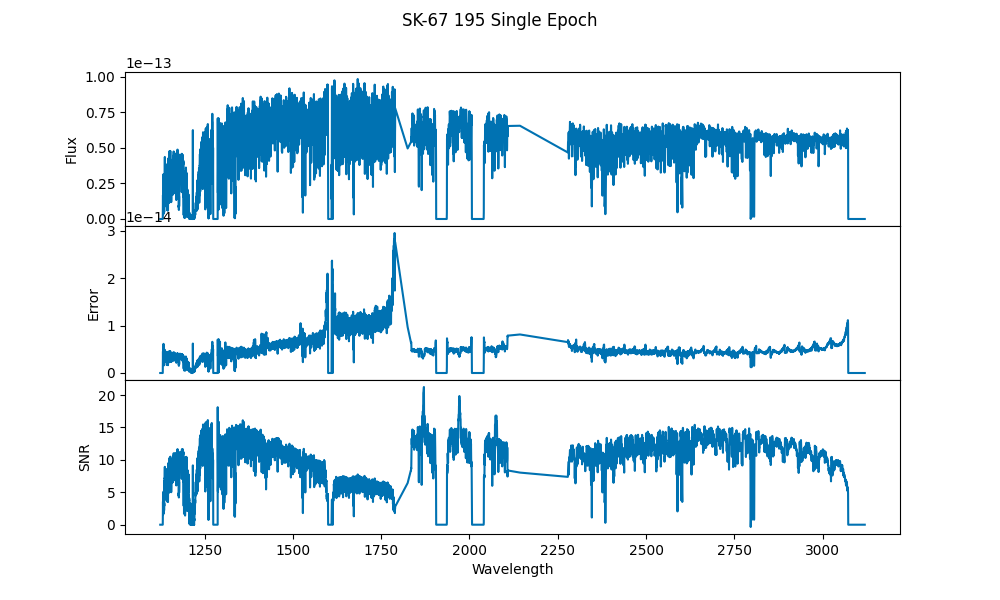

In [7]:
# Make an array to hold the level 2 filenames
level2 = ['hlsp_ullyses_hst_cos_sk-67d195_g130m_dr6_cspec.fits', 'hlsp_ullyses_hst_cos_sk-67d195_g160m_dr6_cspec.fits',
          'hlsp_ullyses_hst_cos_sk-67d195_g185m_dr6_cspec.fits', 'hlsp_ullyses_hst_stis_sk-67d195_e230m_dr6_cspec.fits']

# Set up the plot - start with the level 4 products
fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
axs[0].plot(downsample_1d(wavelength, 10), downsample_1d(flux, 10))
axs[1].plot(downsample_1d(wavelength, 10), downsample_1d(error, 10))
axs[2].plot(downsample_1d(wavelength, 10), downsample_1d(snr, 10))

# Then use a for loop to add the level 2 products on top
for prod in level2:
    with fits.open(prod) as prod_hdu:
        prod_wavelength = prod_hdu[1].data['wavelength']
        prod_flux = prod_hdu[1].data['flux']  
        prod_error = prod_hdu[1].data['error']
        prod_snr = prod_hdu[1].data['snr']
    axs[0].plot(downsample_1d(prod_wavelength, 10), downsample_1d(prod_flux, 10), 'b')
    axs[1].plot(downsample_1d(prod_wavelength, 10), downsample_1d(prod_error, 10), 'c')
    axs[2].plot(downsample_1d(prod_wavelength, 10), downsample_1d(prod_snr, 10), 'r') 

# Add all the labels
plt.suptitle('SK-67 195 Single Epoch')
axs[0].set_ylabel('Flux')
axs[1].set_ylabel('Error')
axs[2].set_ylabel('SNR')
plt.xlabel('Wavelength')
plt.show()


# Note this isn't plotting correctly right now.... :(

Above we can see how the constuent level 2 products compare to the coadded and abutted level 4 product for this target.

In [8]:
# Be sure to close the HDU at the end :)
spec_hdu.close()

<a id="tss"></a>
### Timeseries Spectra

#### FITS File Structure

Spectroscopic time-series spectra (TSS) products are available for both survey and monitoring T Tauri stars. LCOGT data are used to create exposure-level TSS products for both survey and monitoring stars. HST data are used to create both exposure-level and sub-exposure-level TSS products for monitoring targets only.

Like the single epoch spectra, the TSS data and information is stored in two BINTABLE extensions:
- a Science extension for the combined product, and
- a matching Provenance extension to record attributes of each spectrum that contributed to the combined product

Next, we'll download an exposure-level TTS file for a survey star made from LCOGT data.

In [ ]:
# Use curl to download a TSS data product for the target Hn5 (GX Cha)
!curl -L -X GET "https://mast.stsci.edu/api/v0.1/Download/file?uri=mast%3AHLSP%2Fullyses%2Fhn5%2Fdr6%2Fhlsp_ullyses_lcogt_04m_hn5_v-iprime_dr6_tss.fits" --output "hlsp_ullyses_lcogt_04m_hn5_v-iprime_dr6_tss.fits" --fail --create-dirs

In [38]:
# Create a variable to point to the file we just downloaded, then open the file, and print the HDU info
exp_tss_filename = './hlsp_ullyses_lcogt_04m_hn5_v-iprime_dr6_tss.fits'
exp_tss_file = Path(exp_tss_filename)
exp_tss_hdu = fits.open(exp_tss_file)
print(exp_tss_hdu.info())

print()
exp_tss_filename.split('_')

Filename: hlsp_ullyses_lcogt_04m_hn5_v-iprime_dr6_tss.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  SCIENCE       1 BinTableHDU     36   1R x 5C   [100D, 100D, 2E, 200E, 200E]   
  2  PROVENANCE    1 BinTableHDU     37   100R x 12C   [40A, 32A, 32A, 32A, 32A, 32A, 32A, 32A, D, D, D, D]   
None



['./hlsp', 'ullyses', 'lcogt', '04m', 'hn5', 'v-iprime', 'dr6', 'tss.fits']

\
From the filename, `hlsp_ullyses_lcogt_04m_hn5_v-iprime_dr6_tss.fits`, we can see:
- the telescope used is LCOGT
- the instrument used is the 0.4 meter
- the target observed is Hn5
- the optical element is v-iprime
- this file was created for data release 6

Now we'll look at the science and provenance extensions.

#### Time-series Spectra Science Table
The TSS products have slightly different table columns compared to single-epoch spectra. The FLUX and ERROR arrays are 2D arrays with wavelength increasing X, and time increasing along Y. The wavelength values for each column of the 2D data are stored in the WAVELENGTH array, while the MJDSTART and MJDEND columns store the start and end times for each row of the FLUX and ERROR arrays.

In [39]:
# Print the columns in the science extension
print(exp_tss_hdu[1].columns)

# Print the shape of the FLUX array
print('Number of time bins: {}'.format(exp_tss_hdu[1].data['FLUX'][0].shape[0]))
print('Number of spectral bins: {}'.format(exp_tss_hdu[1].data['FLUX'][0].shape[1]))

ColDefs(
    name = 'MJDSTART'; format = '100D'; unit = 'Day'
    name = 'MJDEND'; format = '100D'; unit = 'Day'
    name = 'WAVELENGTH'; format = '2E'; unit = 'Angstrom'
    name = 'FLUX'; format = '200E'; unit = 'erg /s /cm**2 /Angstrom'; dim = '(2, 100)'
    name = 'ERROR'; format = '200E'; unit = 'erg /s /cm**2 /Angstrom'; dim = '(2, 100)'
)
Number of time bins: 100
Number of spectral bins: 2


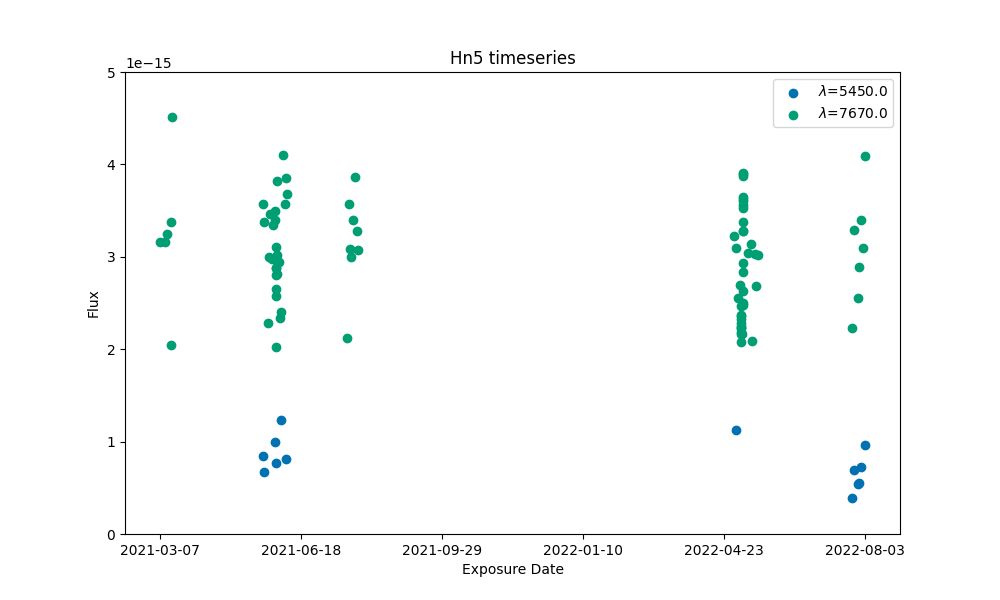

In [61]:
# Plot the flux vs time for each wavelength bin
fig = plt.figure()
wavelength = exp_tss_hdu[1].data['WAVELENGTH'][0]
flux = exp_tss_hdu[1].data['FLUX'][0]
time = exp_tss_hdu[1].data['MJDSTART'][0]
flux_wave1 = np.array([x[0] for x in flux])   # this list comprehension selects the first entry in each row, which is the flux at the first wavelength bin
flux_wave2 = np.array([x[1] for x in flux])   # this does the same, but for the flux of the second wavelength bin

# Filter out the data points that have 0 flux 
filter1 = np.where(flux_wave1 != 0.0)[0]
filter2 = np.where(flux_wave2 != 0.0)[0]

# Set up the plot
plt.scatter(time[filter1], flux_wave1[filter1], label=r'$\lambda$={}'.format(wavelength[0]))
plt.scatter(time[filter2], flux_wave2[filter2], label=r'$\lambda$={}'.format(wavelength[1]))

# Set up the x ticks
mjdticks = np.linspace(time[0], time[-1], 6)
yyyymmdd_date = [Time(t, format='mjd').isot.split('T')[0] for t in mjdticks]    # the split after the 'T' selects the date only
plt.xticks(mjdticks, yyyymmdd_date)

plt.title('Hn5 timeseries')
plt.ylim(0,5e-15)
plt.ylabel('Flux')
plt.xlabel('Exposure Date')
plt.legend()  
plt.show()

#### Time-series Spectra Provenance Table
Select metadata for each spectrum that contributes to the time-series product will populate a row in the provenance table. The fields in the table are metadata harvested from the headers of the contributing spectra. Some columns are only present for HST data or LCOGT data.

In [18]:
# Print the columns in the provenance extension
print(exp_tss_hdu[2].columns)

ColDefs(
    name = 'FILENAME'; format = '40A'
    name = 'PROPOSID'; format = '32A'
    name = 'TELESCOPE'; format = '32A'
    name = 'INSTRUMENT'; format = '32A'
    name = 'DETECTOR'; format = '32A'
    name = 'FILTER'; format = '32A'
    name = 'APERTURE'; format = '32A'
    name = 'CAL_VER'; format = '32A'
    name = 'MJD_BEG'; format = 'D'; unit = 'd'
    name = 'MJD_MID'; format = 'D'; unit = 'd'
    name = 'MJD_END'; format = 'D'; unit = 'd'
    name = 'XPOSURE'; format = 'D'; unit = 's'
)


In [19]:
# We'll use Astropy Tables to make it print out a few of the columns listed above in a neat way

prov_table = Table(exp_tss_hdu[2].data)
prov_table.pprint_include_names = ('FILENAME',
                                   'PROPOSID', 
                                   'INSTRUMENT', 
                                   'DETECTOR', 
                                   'FILTER',
                                   'APERTURE',
                                   'XPOSURE')

# Use pprint to print out the provenance data
prov_table.pprint()

# If you'd like to print all columns use:
# prov_table.pprint_all()

# Or to print a single column use:
# prov_table['FILENAME'].pprint()

                FILENAME                  PROPOSID   INSTRUMENT DETECTOR FILTER APERTURE XPOSURE
--------------------------------------- ------------ ---------- -------- ------ -------- -------
coj0m405-kb88-20210307-0098-e91.fits.fz DDT2021A-001       kb88    LCOGT     ip    LCOGT  10.282
lsc0m409-kb29-20210310-0115-e91.fits.fz DDT2021A-001       kb29    LCOGT     ip    LCOGT  10.285
coj0m403-kb24-20210312-0079-e91.fits.fz DDT2021A-001       kb24    LCOGT     ip    LCOGT   10.23
lsc0m409-kb29-20210314-0117-e91.fits.fz DDT2021A-001       kb29    LCOGT     ip    LCOGT  10.286
coj0m403-kb24-20210315-0118-e91.fits.fz DDT2021A-001       kb24    LCOGT     ip    LCOGT  10.237
coj0m403-kb24-20210316-0099-e91.fits.fz DDT2021A-001       kb24    LCOGT     ip    LCOGT  10.236
coj0m403-kb24-20210521-0080-e91.fits.fz DDT2021A-001       kb24    LCOGT      V    LCOGT  20.229
                                    ...          ...        ...      ...    ...      ...     ...
cpt1m012-fa06-20220730-0066-e9

In [20]:
# Be sure to close the HDU when we are finished exploring!
exp_tss_hdu.close()

#### Sub-exposure level TTS Data Product Example

Next let's check out a TTS file for one of the T Tauri monitoring stars, TW-Hydra.

In [ ]:
# Use curl to download a TSS data product for the target
!curl -L -X GET "https://mast.stsci.edu/api/v0.1/Download/file?uri=mast%3AHLSP%2Fullyses%2Fv-tw-hya%2Fdr7%2Fhlsp_ullyses_hst_cos_v-tw-hya_g160m_dr7_split-tss.fits" --output "hlsp_ullyses_hst_cos_v-tw-hya_g160m_dr7_split-tss.fits" --fail --create-dirs

In [21]:
# Create a variable to point to the file we just downloaded, then open the file, and print the HDU info
subexp_tss_filename = './hlsp_ullyses_hst_cos_v-tw-hya_g160m_dr7_split-tss.fits'
subexp_tss_file = Path(subexp_tss_filename)
subexp_tss_hdu = fits.open(subexp_tss_file)
print(subexp_tss_hdu.info())

print()
subexp_tss_filename.split('_')

Filename: hlsp_ullyses_hst_cos_v-tw-hya_g160m_dr7_split-tss.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  SCIENCE       1 BinTableHDU     40   1R x 5C   [720D, 720D, 11562E, 8324640E, 8324640E]   
  2  PROVENANCE    1 BinTableHDU     47   720R x 16C   [40A, 32A, 32A, 32A, 32A, 32A, 32A, 32A, D, 32A, D, D, D, D, D, D]   
None



['./hlsp',
 'ullyses',
 'hst',
 'cos',
 'v-tw-hya',
 'g160m',
 'dr7',
 'split-tss.fits']

\
From the filename, `hlsp_ullyses_hst_cos_v-tw-hya_g160m_dr7_split-tss.fits`, we can see:
- the telescope used is HST
- the instrument used is COS
- the target observed is v-tw-hya (aka TW Hydra)
- the optical element is G160M
- this file was created for data release 7

Now we'll look at the science and provenance extensions.

In [22]:
# Print the columns in the science extension
print(subexp_tss_hdu[1].columns)

# Print the shape of the FLUX array
print('Number of time bins: {}'.format(subexp_tss_hdu[1].data['FLUX'][0].shape[0]))
print('Number of spectral bins: {}'.format(subexp_tss_hdu[1].data['FLUX'][0].shape[1]))

ColDefs(
    name = 'MJDSTART'; format = '720D'; unit = 'Day'
    name = 'MJDEND'; format = '720D'; unit = 'Day'
    name = 'WAVELENGTH'; format = '11562E'; unit = 'Angstrom'
    name = 'FLUX'; format = '8324640E'; unit = 'erg /s /cm**2 /Angstrom'; dim = '(11562, 720)'
    name = 'ERROR'; format = '8324640E'; unit = 'erg /s /cm**2 /Angstrom'; dim = '(11562, 720)'
)
Number of time bins: 720
Number of spectral bins: 11562


In [ ]:
# Print the columns in the provenance extension
print(subexp_tss_hdu[2].columns)

In [23]:
# We'll use Astropy Tables to make it print out a few of the columns listed above in a neat way

prov_table = Table(subexp_tss_hdu[2].data)
prov_table.pprint_include_names = ('FILENAME', 
                                   'PROPOSID', 
                                   'INSTRUMENT', 
                                   'DETECTOR', 
                                   'FILTER', 
                                   'APERTURE', 
                                   'XPOSURE',
                                   'MJD_MID')

# Use pprint to print out the provenance data
prov_table.pprint()

# If you'd like to print all columns use:
# prov_table.pprint_all()

# Or to print a single column use:
# prov_table['FILENAME'].pprint()

        FILENAME         PROPOSID INSTRUMENT DETECTOR APERTURE      MJD_MID       XPOSURE
------------------------ -------- ---------- -------- -------- ------------------ -------
le9d1cdiq_corrtag_a.fits    16109        COS      FUV      PSA  59302.68690230111    30.0
le9d1cdiq_corrtag_a.fits    16109        COS      FUV      PSA  59302.68724952334    30.0
le9d1cdiq_corrtag_a.fits    16109        COS      FUV      PSA 59302.687596745556    30.0
le9d1cdiq_corrtag_a.fits    16109        COS      FUV      PSA  59302.68794396777    30.0
le9d1cdiq_corrtag_a.fits    16109        COS      FUV      PSA     59302.68829119    30.0
le9d1cdiq_corrtag_a.fits    16109        COS      FUV      PSA  59302.68863841222    30.0
le9d1cdiq_corrtag_a.fits    16109        COS      FUV      PSA  59302.68898563445    30.0
                     ...      ...        ...      ...      ...                ...     ...
lepcaghiq_corrtag_a.fits    16591        COS      FUV      PSA  59695.42465000111    30.0
lepcaghiq_

From the above provenance table output, the XPSOURE column shows us that each exposure was split into 30 second time bins to create this sub-exposure TSS product.

(-1e-13, 2.2e-12)

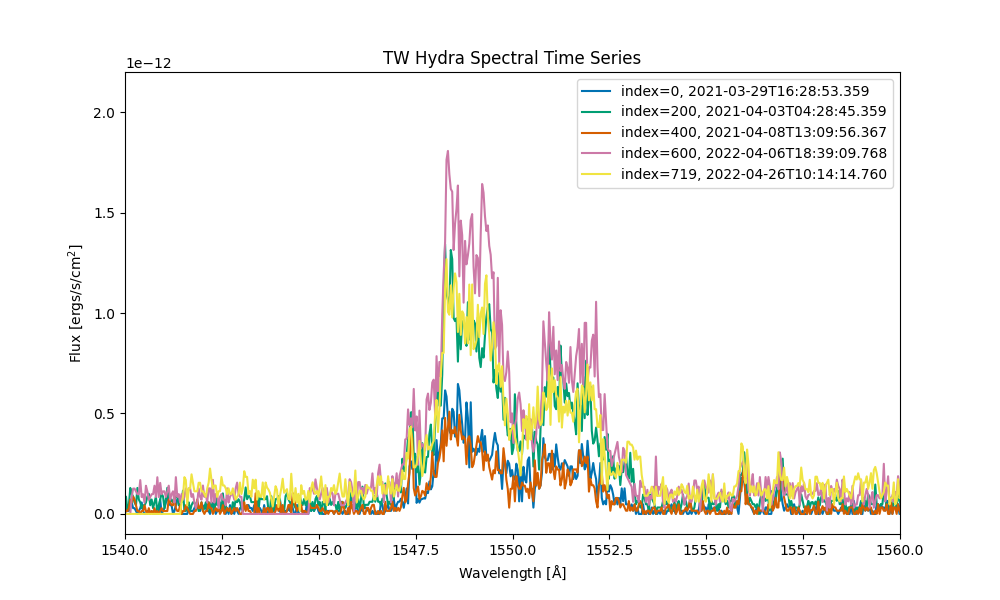

In [35]:
fig = plt.figure()

# Make useful variable names for the pertinent columns in the file
flux = subexp_tss_hdu[1].data['flux'][0]
wavelength = subexp_tss_hdu[1].data['wavelength'][0]
mjdstart = [Time(t, format='mjd').isot for t in subexp_tss_hdu[1].data['mjdstart'][0]]
mjdend = [Time(t, format='mjd').isot for t in subexp_tss_hdu[1].data['mjdend'][0]]

# Since there are 720 time bins, we pick some random indices and plot the spectra corresponding to those times
indices = [0, 200, 400, 600, 719]
for i, ind in enumerate(indices):
    plt.plot(wavelength, flux[ind], label=f'index={ind}, {mjdstart[ind]}')
plt.legend()
plt.xlabel('Wavelength [$\mathrm{\AA}$]')
plt.ylabel('Flux [ergs/s/cm$\mathrm{^2}$]')
plt.title('TW Hydra Spectral Time Series')
plt.xlim(1540, 1560)
plt.ylim(-0.1e-12, 2.2e-12)

Let's make one more plot of this data, looking over a shorter time scale now (~a day). We'll only change the `indices` list.

(-1e-13, 2.2e-12)

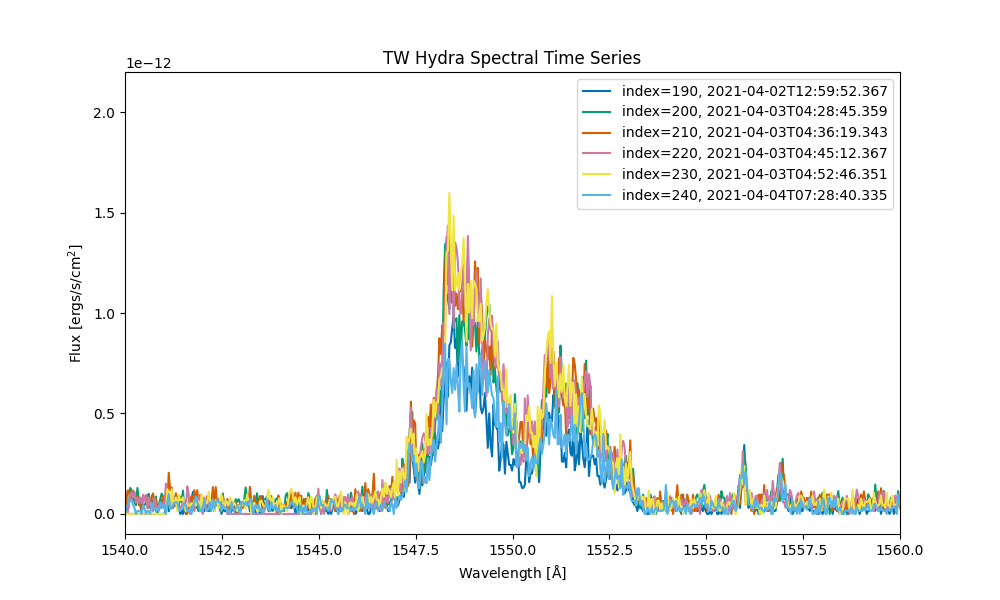

In [68]:
fig = plt.figure()

# Make useful variable names for the pertinent columns in the file
flux = subexp_tss_hdu[1].data['flux'][0]
wavelength = subexp_tss_hdu[1].data['wavelength'][0]
mjdstart = [Time(t, format='mjd').isot for t in subexp_tss_hdu[1].data['mjdstart'][0]]
mjdend = [Time(t, format='mjd').isot for t in subexp_tss_hdu[1].data['mjdend'][0]]

indices = np.arange(190, 250, 10)
for i, ind in enumerate(indices):
    plt.plot(wavelength, flux[ind], label=f'index={ind}, {mjdstart[ind]}')
plt.legend()
plt.xlabel('Wavelength [$\mathrm{\AA}$]')
plt.ylabel('Flux [ergs/s/cm$\mathrm{^2}$]')
plt.title('TW Hydra Spectral Time Series')
plt.xlim(1540, 1560)
plt.ylim(-0.1e-12, 2.2e-12)

In [ ]:
# Be sure to close the HDU when we are finished exploring!
subexp_tss_hdu.close()

<a id="drizzle"></a>
### WFC3 Drizzled Images

#### FITS File Structure

Drizzled and weight images are stored in two IMAGEHDU extensions, and PROVENANCE information stored in a BINTABLE extension:
- a Science extension for the drizzled science image
- a Weight extension for the weight map image
- a matching Provenance extension to record attributes of each image that contributed to the combined product

Last, we'll explore a drizzled image of Sextans A observed with WFC3 with the F336W filter.

In [ ]:
# Download the data product
!curl -L -X GET "https://mast.stsci.edu/api/v0.1/Download/file?uri=mast%3AHLSP%2Fullyses%2Fsextans-a%2Fdr6%2Fhlsp_ullyses_hst_wfc3_sextans-a_f336w_dr6_drc.fits" --output "hlsp_ullyses_hst_wfc3_sextans-a_f336w_dr6_drc.fits" --fail --create-dirs

In [ ]:
# Create a variable to point to the file we just downloaded, open the file, and print the HDU info
drz_file = Path('./hlsp_ullyses_hst_wfc3_sextans-a_f336w_dr6_drc.fits')
drz_hdu = fits.open(drz_file)
print(drz_hdu.info())

\
From the filename, we can see:
- the telescope used is HST
- the instrument used is WFC3
- the optical element is F336W
- this file was created for data release 6

Now we'll look at the science, weight, and provenance extensions.

#### Drizzled Image Science Extension

This extension is an image array that contains the drizzled image data.

In [ ]:
# Print the size of the drizzled image that's in the science extension
print(drz_hdu[1].shape)

In [ ]:
# Plot the drizzled image
fig = plt.figure()
drz_data = drz_hdu[1].data
wcs = WCS(drz_hdu[1].header)  # this creates a WCS object from the image header coordinate information

plt.subplot(projection=wcs)
plt.imshow(drz_data, vmin=0, vmax=0.03)

plt.title('Sextans A - F336W')
plt.grid(color='white', ls=':', alpha=0.7)
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()

#### Drizzled Image Weight Map Extension

This extension is another image array that contains the weight map data. The weight map is ...

In [ ]:
# Print the size of the weight map, which is the second extension. This should be the same as the drizzled image
print(drz_hdu[2].shape)

In [ ]:
# Plot the weight map
fig = plt.figure()
wgt_data = drz_hdu[2].data
wcs = WCS(drz_hdu[2].header)

plt.subplot(projection=wcs)
plt.imshow(wgt_data, vmin=0, vmax=1)

plt.title('Sextans A - F336W - weight map')
plt.grid(color='white', ls=':')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()

#### Drizzled Image Provenance Table

Select metadata for each image that contributes to the drizzled image in will populate a row in the provenance table. The fields in the  table are metadata harvested from the headers of the contributing images.

In [ ]:
# Print the columns in the provenance extension
print(drz_hdu[3].columns)

In [ ]:
# We'll again use Astropy Tables to make it print out a few of the columns listed above in a neat way

prov_table = Table(drz_hdu[3].data)
prov_table.pprint_include_names = ('FILENAME', 
                                   'PROPOSID',
                                   'INSTRUMENT',
                                   'DETECTOR', 
                                   'FILTER', 
                                   'APERTURE',
                                   'XPOSURE')

# Use pprint to print out the provenance data
prov_table.pprint()

# If you'd like to print all columns use:
# prov_table.pprint_all()

# Or to print a single column use:
# prov_table['FILENAME'].pprint()

In [ ]:
# Close the DRZ HDU!
drz_hdu.close()

***

## Additional Resources

- [ULLYSES](https://ullyses.stsci.edu)
- [MAST API](https://mast.stsci.edu/api/v0/index.html)

## About this Notebook
For support, contact us at the [ULLYSES Helpdesk](https://stsci.service-now.com/hst?id=sc_cat_item&sys_id=a3b8ec5edbb7985033b55dd5ce961990&sysparm_category=ac85189bdb4683c033b55dd5ce96199c).

**Author:**  Elaine M Frazer \
**Updated On:** 2023-11-17

## Citations
* See the [ULLYSES website](https://ullyses.stsci.edu/ullyses-cite.html) for citation guidelines.


***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 